### Initialize the environment

In [1]:
import theano
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
src_dir='../src' # source directory
run_dir_prefix='../MDBN_run/AML_Batch_' # directory with the results of previous runs
data_dir='../data' # directory with the data files

In [3]:
import sys
sys.path.insert(0, src_dir)
import rbm
import MDBN
import main

### Load the experiment results

In [4]:
run=1
date_time='2017-02-20_2302' # specify the date and time of the run in the format YYYY-MM-DD_HHMM
run_dir=run_dir_prefix+date_time
runfile='Exp_%s_run_%s.npz' % (date_time, run) # location of the experiment results
config, dbn_dict = MDBN.load_network(runfile, run_dir)

In [5]:
config

{u'dbns': {u'GE': {u'batchSize': 1,
   u'datafile': u'AML/AML_gene_expression_table2.csv.gz',
   u'epochs': [2, 800],
   'inputNodes': 19937,
   u'k': 1,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [400, 40],
   u'lr': [0.0005, 0.1],
   u'persistent': False},
  u'ME': {u'batchSize': 1,
   u'datafile': u'AML/AML_miRNA_Seq_table2.csv.gz',
   u'epochs': [2],
   'inputNodes': 559,
   u'k': 10,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [40],
   u'lr': [0.005],
   u'persistent': False},
  u'SM': {u'batchSize': 1,
   u'datafile': u'AML/AML_somatic_mutations_table2.csv.gz',
   u'epochs': [2, 800],
   'inputNodes': 1686,
   u'k': 1,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [200, 20],
   u'lr': [0.01, 0.1],
   u'persistent': False}},
 u'p': 1.0,
 u'pathways': [u'ME', u'GE', u'SM'],
 u'runs': 4,
 u'seed': 1234,
 u'top': {u'batchSize': 1,
  u'epochs': [800, 800],
  'inputNodes': 100,
  u'k': 1,
  u'layersNodes': [24, 3],
  u'lr': [0.1, 0.1],
  u'persistent': False},
 u'uuid': u'9bbefc05

### Load the data

In [6]:
datafiles = main.prepare_TCGA_datafiles("AML",config,data_dir)

In [7]:
import utils
real_set, _ = utils.load_n_preprocess_data(datafiles['ME'],datadir=data_dir)
real_set.get_value().shape

(170, 559)

#### Compute the joint layer components

In [8]:
dbn_output_list=[]
for key in config['pathways']:
    dbn_output, _ = dbn_dict[key].MLP_output_from_datafile(datafiles[key], datadir=data_dir)
    dbn_output_list.append(dbn_output)

In [9]:
#dbn_output = dbn_dict['ME'].get_output(theano.shared(np.zeros(real_set.get_value().shape,
#                                                                        dtype=theano.config.floatX),borrow=True))
dbn_output = np.zeros((real_set.get_value().shape[0],40),dtype=theano.config.floatX)

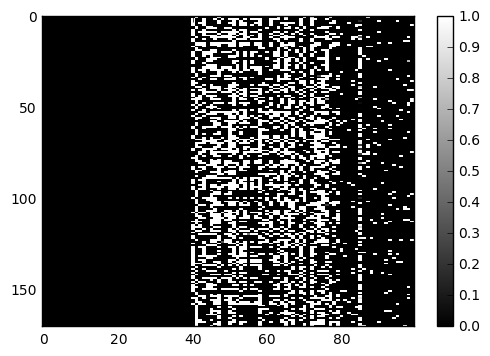

In [10]:
joint_layer = np.concatenate([dbn_output,dbn_output_list[1],dbn_output_list[2]],axis=1)
plt.imshow(joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

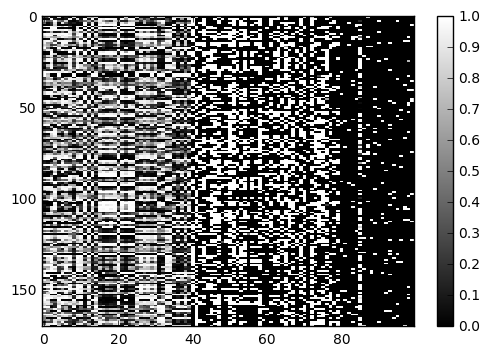

In [11]:
real_joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(real_joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

In [12]:
top_output = dbn_dict['top'].get_output(joint_layer)

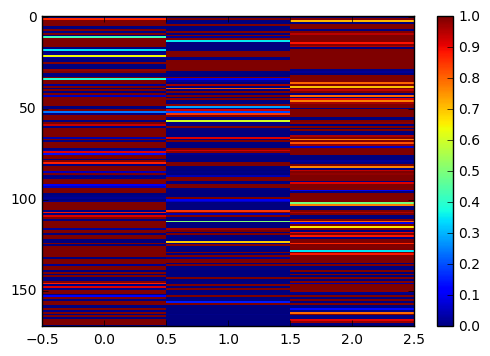

In [14]:
plt.imshow(top_output, interpolation='none')
plt.axis('tight')
plt.colorbar()

In [15]:
top_dbn_rbm1 = dbn_dict['top'].rbm_layers[1]

In [17]:
reload(rbm)
sampled_hidden_layer = top_dbn_rbm1.reverse_sampling(1,theano.shared(top_output,borrow=True))

 ... computing sample 0


In [19]:
sampled_hidden_layer[0].shape

(170, 24)

In [12]:
top_dbn_rbm0 = dbn_dict['top'].rbm_layers[0]

In [13]:
reload(rbm)
sampled_joint_layer = top_dbn_rbm0.sampling(1,theano.shared(joint_layer,borrow=True))

 ... computing sample 0


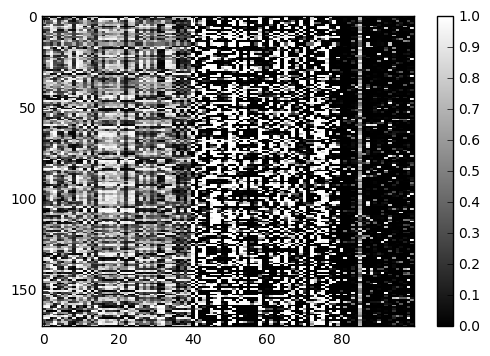

In [14]:
plt.imshow(sampled_joint_layer[0], interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

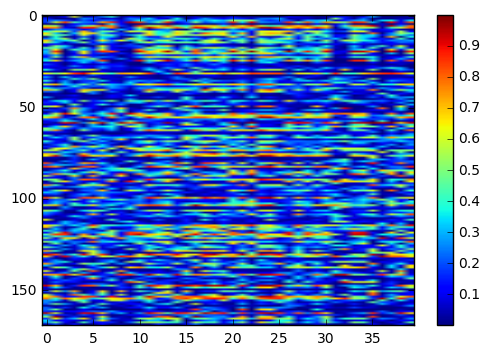

In [15]:
plt.imshow(np.sqrt(np.square(real_joint_layer[:,:40]-sampled_joint_layer[0][:,:40])))
plt.axis('tight')
plt.colorbar()

In [16]:
me_rbm = dbn_dict['ME'].rbm_layers[0]

In [17]:
h1 = theano.tensor.matrix('h1')
vis_layer = me_rbm.sample_v_given_h(h1)

In [18]:
fn = theano.function([h1], vis_layer)

In [19]:
sample_vis_layer = fn(sampled_joint_layer[0][:,:40])

In [20]:
sample_vis_layer[1].shape

(170, 559)

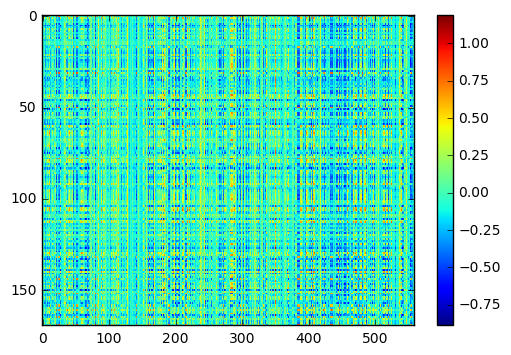

In [21]:
plt.imshow(sample_vis_layer[2],interpolation='none')
plt.axis('tight')
plt.colorbar()

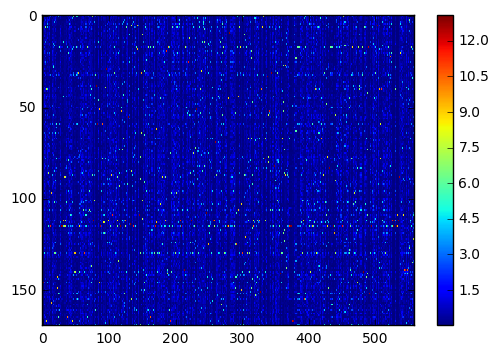

In [22]:
plt.imshow(np.sqrt(np.square(real_set.get_value()-sample_vis_layer[2])),interpolation='none')
plt.axis('tight')
plt.colorbar()

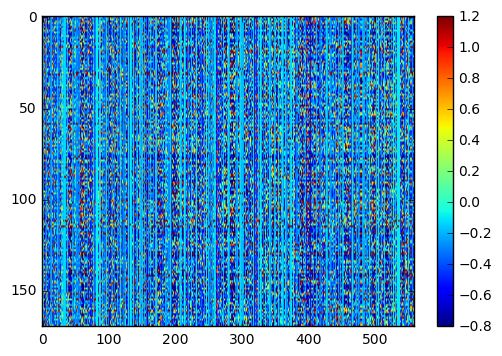

In [23]:
plt.imshow(real_set.get_value(),clim=(-0.8,1.2))
plt.axis('tight')
plt.colorbar()

In [56]:
c = []
for i in range(170):
    rmse = np.sqrt(np.sum(np.square(real_set.get_value()[i]-sample_vis_layer[2][i])[0]))
    if rmse < 3:
        c.append(rmse)
    else:
        print i,rmse

40 6.28492
97 6.27826
146 6.36743
163 6.37166


(array([ 12.,   9.,  15.,  25.,  31.,  26.,  27.,   8.,   6.,   7.]),
 array([ 0.12788093,  0.15591951,  0.18395809,  0.21199667,  0.24003525,
         0.26807383,  0.29611241,  0.32415099,  0.35218956,  0.38022814,
         0.40826672]),
 <a list of 10 Patch objects>)

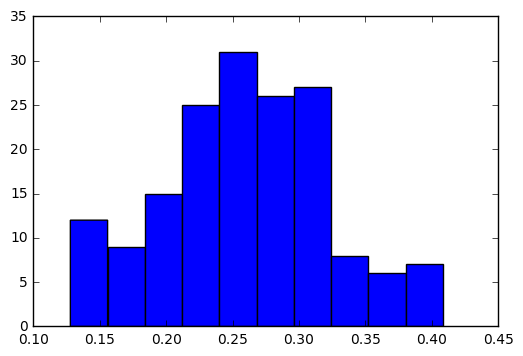

In [57]:
plt.hist(c)

In [58]:
np.mean(c)

0.25933504